# start

In [1]:
TGT='Retweet'
PRFX='Retweet0521A2'

trntmstmp=1584412344
tsttmstmp=1590075806

tm_trn_min,tm_trn_max=(1580947200, 1581551999)
tm_tst_min,tm_tst_max=(1581552000, 1582156799)

train_total=148075238
test_total=int(1.4e7)
print(f'train_total {train_total:,}, test_total {test_total:,}')

SEED=101

trnsz = int(1e7)
valsz = trnsz//10
print(f'train_total {trnsz:,}, valsz {valsz:,}')



import datetime
def showtm(tm): return datetime.datetime.fromtimestamp(tm).strftime('%Y-%m-%d %H:%M:%S')
print([showtm(tm) for tm in (trntmstmp, tsttmstmp)])
print([showtm(tm) for tm in (tm_trn_min,tm_trn_max)])
print([showtm(tm) for tm in (tm_tst_min,tm_tst_max)])

train_total 148,075,238, test_total 14,000,000
train_total 10,000,000, valsz 1,000,000
['2020-03-17 02:32:24', '2020-05-21 15:43:26']
['2020-02-06 00:00:00', '2020-02-12 23:59:59']
['2020-02-13 00:00:00', '2020-02-19 23:59:59']


# setup

In [2]:
from tqdm import tqdm
import time
from pathlib import Path
from collections import Counter,defaultdict
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
import pickle
# import xgboost as xgb
import lightgbm as lgb
import category_encoders as ce
import gc

import optuna
# optuna.logging.CRITICAL, optuna.logging.FATAL
# optuna.logging.ERROR
# optuna.logging.WARNING, optuna.logging.WARN
# optuna.logging.INFO
# optuna.logging.DEBUG
# optuna.logging.set_verbosity(optuna.logging.ERROR)
import optuna.integration.lightgbm as lgb
optuna.logging.disable_default_handler()


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

def iou(s1,s2):
    return len(s1&s2) / len(s1|s2)

HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

# https://towardsdatascience.com/how-to-calibrate-undersampled-model-scores-8f3319c1ea5b
# How to use the function?
# Let’s say your goal is to generate a model that shows the credit default probabilities and your original 
# training data has 50,000 rows with only 500 of them labeled as target class. When you sample your non-target 
# instances randomly and reduce the total row count to 10,000, while conserving 500 target rows, our calibration
# function becomes:
# calibration(model_results, 50000, 500, 10000, 500)
# Here model_results is your model probability output array. After you train your model and put the results in it, your function is ready to use. 
def calibration(data, train_pop, target_pop, sampled_train_pop, sampled_target_pop):
    calibrated_data = ((data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop)) /
    (((1 - data) * (1 - target_pop / train_pop) / (1 - sampled_target_pop / sampled_train_pop)) +
     (data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop))))
    return calibrated_data


cols=['toks','hshtgs','twtid','media','links','domns','twttyp','lang','tm','u1id','u1_fllwer_cnt','u1_fllwing_cnt','u1_vrfed','u1_create_tm','u2id','u2_fllwer_cnt','u2_fllwng_cnt','u2_vrfed','u2_create_tm','u1_fllw_u2','reply_tm','retwt_tm','retwt_cmmnt_tm','like_tm',]

cols_val = cols[:-4]
cols_tgt_tmstmp=[ 'retwt_tm', 'reply_tm', 'like_tm', 'retwt_cmmnt_tm',]
cols_tgt=[o.split('_tm')[0] for o in cols_tgt_tmstmp]
tgts             = ['Retweet','Reply','Like','RTwCmnt',]
assert cols_tgt == ['retwt',  'reply','like','retwt_cmmnt',]
tgt2col = dict(zip(tgts, cols_tgt))
TCOL=tgt2col[TGT]
print('TCOL', TCOL)
print(tgt2col)

TCOL retwt
{'Retweet': 'retwt', 'Reply': 'reply', 'Like': 'like', 'RTwCmnt': 'retwt_cmmnt'}


# prep

In [3]:
def prp_tgt(df):
    df[cols_tgt]=df[cols_tgt_tmstmp].notna()
    df.drop(columns=cols_tgt_tmstmp, inplace=True)
    display(df[cols_tgt].mean())

In [4]:
%%time
dfval = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=valsz)
print(dfval.shape)
prp_tgt(dfval)

(1000000, 24)


retwt          0.113135
reply          0.027688
like           0.438804
retwt_cmmnt    0.007750
dtype: float64

CPU times: user 11.1 s, sys: 1.44 s, total: 12.5 s
Wall time: 13.8 s


## maybe oversample

In [5]:
# df = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=5)
# dfval = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=2)
# dftrn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,skiprows=2,nrows=3)
# display(df.twtid)
# display(dfval.twtid)
# display(dftrn.twtid)

# 0    D4D1EBDE74F74C5DA529959AF979625C
# 1    BFB529DAB6D384EB83E899A72AB3830D
# 2    519078C7834E9642508F72A6C2D0F3B7
# 3    52AAE9E33EFAC8C478C57B31A9E31ED1
# 4    89C1298C55EB3D68E2784F0BFB69E6F8
# Name: twtid, dtype: object
# 0    D4D1EBDE74F74C5DA529959AF979625C
# 1    BFB529DAB6D384EB83E899A72AB3830D
# Name: twtid, dtype: object
# 0    519078C7834E9642508F72A6C2D0F3B7
# 1    52AAE9E33EFAC8C478C57B31A9E31ED1
# 2    89C1298C55EB3D68E2784F0BFB69E6F8
# Name: twtid, dtype: object

In [6]:
%%time
if TGT in ('Retweet','Like'): trnpop=trnsz
if TGT=='Reply': trnpop=trnsz*3.7
if TGT=='RTwCmnt': trnpop=trnsz*11.5
assert trnpop<train_total

dftrn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,
                     skiprows=valsz, nrows=trnpop)
print(dftrn.shape)
prp_tgt(dftrn)

(10000000, 24)


retwt          0.113119
reply          0.027466
like           0.439466
retwt_cmmnt    0.007776
dtype: float64

CPU times: user 1min 46s, sys: 11.9 s, total: 1min 57s
Wall time: 2min 6s


In [7]:
train_pop=len(dftrn)
sampled_train_pop=trnsz
idx_pos = np.where(dftrn[TCOL])[0]
target_pop=sampled_target_pop=len(idx_pos)
if TGT in ('Reply','RTwCmnt'):
    idx_neg0 = np.where(~dftrn[TCOL])[0]
    idx_neg = np.random.choice(idx_neg0, trnsz-len(idx_pos), replace=False)
    idx = np.concatenate([idx_pos,idx_neg])
    dftrn = dftrn.iloc[idx].copy()
print(dftrn.shape, dftrn[TCOL].mean())
print(train_pop, target_pop, sampled_train_pop, sampled_target_pop)

display(dftrn.head())
display(dftrn.columns)

(10000000, 24) 0.1131194
10000000 1131194 10000000 1131194


,toks,hshtgs,twtid,media,links,domns,twttyp,lang,tm,u1id,u1_fllwer_cnt,u1_fllwing_cnt,u1_vrfed,u1_create_tm,u2id,u2_fllwer_cnt,u2_fllwng_cnt,u2_vrfed,u2_create_tm,u1_fllw_u2,retwt,reply,like,retwt_cmmnt
0,101\t9706\t36553\t108578\t119\t119\t119\t108\t...,11218D05D5E94DE4E577C3AF9338E65D\t3A6FF9E6FA11...,E0B1129F0B31CAE6655127073C08979C,Photo,NaN,NaN,TopLevel,125C57F4FA6D4E110983FB11B52EFD4E,1581348967,30D18739CC163E7629104D16BE4E65DF,13537,114,False,1534442935,0DD2A83B6837B1FA23CEA85748175A46,95,354,False,1348229207,False,True,False,False,False
1,101\t56898\t137\t12655\t168\t10514\t10115\t131...,NaN,99E58F0E8DADFB4BAF9EEA0E93694AAE,Photo\tPhoto\tPhoto\tPhoto,NaN,NaN,Retweet,22C448FF81263D4BAF2A176145EE9EAD,1581391499,458AF1D57377287A0BAB2A56AA3EE4AC,136,688,False,1429565372,0DD2A9EE937B01347709DE173E6E1E47,74,181,False,1496325843,True,False,False,True,False
2,101\t56898\t137\t24109\t10506\t168\t21881\t113...,NaN,9A3C7C7654F75C478EC3922E60AD0039,Photo,NaN,NaN,Retweet,ECED8A16BE2A5E8871FD55F4842F16B1,1581460690,356534AF79A703A631CA45EF95F702C9,466,805,False,1402911598,0DD2AA5E775014DC55292B2B7E80619E,215,436,False,1451672532,True,False,False,True,False
3,101\t56898\t137\t53542\t14985\t11537\t28754\t1...,NaN,4F7E51D4C05BC27B8F29CCE39BA5CA95,Photo\tPhoto,NaN,NaN,Retweet,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581324557,221780A4B90649CB87AC0CBA7102A2AC,3491,2001,False,1231675403,0DD2AACDA7259687F9FD27A6CA3A0614,143,254,False,1375373900,True,False,False,True,False
4,101\t199\t143\t27128\t32002\t106\t137\t17673\t...,35D2EF13596CAC1B15863EF3CAB39A2E\t85ADB30A7FFB...,9035B7BA255DE0118FA0F41D2BB897A2,Photo,B490D14EB0D08709727B4CEE188641AA,26D558AFEEDD2EDC37CB4A5E7042E1C4,TopLevel,06D61DCBBE938971E1EA0C38BD9B5446,1581162933,DBE3576D0E67C652379202D7202B874F,5210115,1583,True,1211799913,0DD2AAD677632C842DE89D7BB43AA453,226,330,False,1576352487,False,False,False,False,False


Index(['toks', 'hshtgs', 'twtid', 'media', 'links', 'domns', 'twttyp', 'lang',
       'tm', 'u1id', 'u1_fllwer_cnt', 'u1_fllwing_cnt', 'u1_vrfed',
       'u1_create_tm', 'u2id', 'u2_fllwer_cnt', 'u2_fllwng_cnt', 'u2_vrfed',
       'u2_create_tm', 'u1_fllw_u2', 'retwt', 'reply', 'like', 'retwt_cmmnt'],
      dtype='object')

## prep and features

In [8]:
def prp_df(df, tm_max):
    '''
    tm_max = tm_trn_max for train tm_tst_max for test
    '''
    lendf = len(df)
    print(dtnow(), 'start')
    set_u1 = set(df.u1id)
    set_u2 = set(df.u2id)
    df['u1inu2']=df.u1id.isin(set_u2)
    df['u2inu1']=df.u2id.isin(set_u1)

    #counts
    df['len_toks'] = df.toks.apply(lambda x: len(x.split('\t')))
    df.drop(columns=['toks'], inplace=True)    
    for m in ['Photo', 'Video', 'GIF']:
        df[f'n_media_{m}'] = df['media'].fillna('').apply(lambda x: x.split('\t').count(m))
    tgnms = ['hshtgs','media', 'links', 'domns',]
    for tgnm in tgnms:
        df[f'has_{tgnm}']=df[tgnm].notna()
        df[f'lst_{tgnm}'] = df[tgnm].fillna('').apply(lambda x: x.split('\t') if len(x) else [])
        df[f'n_{tgnm}'] = df[f'lst_{tgnm}'].apply(len)  
    df.drop(columns=['has_links','n_links'], inplace=True) #duplicates has_domns,n_domns 
    
    #time
    dt = pd.to_datetime(df.tm, unit='s')
    df['dayofweek'] = dt.dt.dayofweek
    df['hour'] = dt.dt.hour
    
    df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm
    df['tmdlta_twtu1'] = df.tm - df.u1_create_tm
    df['tmdlta_twtu2'] = df.tm - df.u2_create_tm

    df['twt_age']   = tm_max-df.tm
    df['u1_age']    = tm_max-df.u1_create_tm
    df['u2_age']    = tm_max-df.u2_create_tm
    df.drop(columns=['tm', 'u1_create_tm', 'u2_create_tm'], inplace=True)

    #time derived
    df['u1_fllwer_cnt_by_age'] = df.u1_fllwer_cnt / df.u1_age
    df['u1_fllwng_cnt_by_age'] = df.u2_fllwng_cnt / df.u2_age
    
    #interaction
    df['u1u2']=df.u1id+'_'+df.u2id
    df['langhour']=df.lang+'_'+df.hour.astype(str)
    

#     #freq of feature values
#     print(dtnow(), 'freq of columns using CountEncoder')
#     encoder = ce.CountEncoder()
#     encoded = encoder.fit_transform(
#     df[['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwing_cnt', 'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_vrfed', 'u1_fllw_u2', 
#        'n_media_Photo', 'n_media_Video', 'n_media_GIF', 
#        'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media','has_domns', 'n_domns', 
#        'dayofweek', 'hour', 'u1u2', 'langhour']].astype(object))
#     encoded = encoded.astype(int)/lendf
#     encoded.columns = [f'frq_{col}' for col in encoded.columns]
#     df = pd.concat([df,encoded],1)
    
    #freq of tgnm values
#     print(dtnow(), 'freq of tags')
#     for tgnm in tgnms:
#         vs = [j for i in df[f'lst_{tgnm}'] for j in i]
#         cnt = Counter(vs)
#         frq = {k:v/lendf for k,v in cnt.items()}
#         df[f'sumfrq_{tgnm}']=df[f'lst_{tgnm}'].apply(lambda x: sum([frq.get(o,0) for o in x]))
#         df[f'maxfrq_{tgnm}']=df[f'lst_{tgnm}'].apply(lambda x: max([frq.get(o,0) for o in x]) if len(x) else 0)
    
    df.drop(columns=tgnms+[f'lst_{tgnm}' for tgnm in tgnms],inplace=True)

    print(dtnow(), 'done')
    return df

In [9]:
%%time
dftrn=prp_df(dftrn, tm_max=tm_trn_max)

2020-05-22 01:00:52 start
2020-05-22 01:06:44 done
CPU times: user 4min 28s, sys: 45.8 s, total: 5min 13s
Wall time: 5min 53s


In [10]:
%%time
dfval=prp_df(dfval, tm_max=tm_trn_max)

2020-05-22 01:06:46 start
2020-05-22 01:07:34 done
CPU times: user 21.9 s, sys: 2.56 s, total: 24.5 s
Wall time: 48.2 s


## tr vl split

In [11]:
msk_vl=np.random.rand(len(dftrn))<0.15
idxvl=np.where( msk_vl)[0]
idxtr=np.where(~msk_vl)[0]

dftr = dftrn.iloc[idxtr].copy()
dfvl = dftrn.iloc[idxvl].copy()
del dftrn

gc.collect()

30

In [12]:
cols_category=['twttyp', 'lang', 'langhour']
for df in dftr,dfvl,dfval:
    df.drop(columns=['twtid','u1id','u2id','u1u2'], inplace=True)
    df[cols_category]=df[cols_category].astype('category')

In [13]:
cols_feat = [col for col in dftr.columns if col not in cols_tgt]

# model

## cols_feat

In [14]:
cols_feat

['twttyp',
 'lang',
 'u1_fllwer_cnt',
 'u1_fllwing_cnt',
 'u1_vrfed',
 'u2_fllwer_cnt',
 'u2_fllwng_cnt',
 'u2_vrfed',
 'u1_fllw_u2',
 'u1inu2',
 'u2inu1',
 'len_toks',
 'n_media_Photo',
 'n_media_Video',
 'n_media_GIF',
 'has_hshtgs',
 'n_hshtgs',
 'has_media',
 'n_media',
 'has_domns',
 'n_domns',
 'dayofweek',
 'hour',
 'tmdlta_u2u1',
 'tmdlta_twtu1',
 'tmdlta_twtu2',
 'twt_age',
 'u1_age',
 'u2_age',
 'u1_fllwer_cnt_by_age',
 'u1_fllwng_cnt_by_age',
 'langhour']

In [15]:
print(len(cols_feat))


32


In [16]:
results = {}
results['PRFX'] = PRFX
results['TGT'] = TGT
results['cols_feat'] = cols_feat

In [17]:
params={
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': 0,    
}

results['params'] = params

In [ ]:
%%time
dtr = lgb.Dataset(dftr[cols_feat], label=dftr[TCOL])
dvl = lgb.Dataset(dfvl[cols_feat], label=dfvl[TCOL])
best_params, tuning_history = {}, []
evalres = {}
evallist = [(dtr, 'train'), (dvl, 'eval')]
bst = lgb.train(params=params, 
                train_set=dtr, 
                num_boost_round=50000,
                valid_sets=[dtr, dvl],
                valid_names=['tr','vl'],
                best_params=best_params,
                tuning_history=tuning_history,
                verbose_eval=100,
                early_stopping_rounds=100,
                evals_result=evalres,
               )
results['bst'] = bst
results['evalres'] = evalres
results['best_params']=best_params
results['tuning_history']=tuning_history

/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/optuna/_experimental.py:87: ExperimentalWarning: train is experimental (supported from v0.18.0). The interface can change in the future.
  ExperimentalWarning
tune_feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.306683	vl's binary_logloss: 0.307146
[200]	tr's binary_logloss: 0.303975	vl's binary_logloss: 0.304944
[300]	tr's binary_logloss: 0.302559	vl's binary_logloss: 0.303973
[400]	tr's binary_logloss: 0.301419	vl's binary_logloss: 0.303265
[500]	tr's binary_logloss: 0.30051	vl's binary_logloss: 0.302771
[600]	tr's binary_logloss: 0.299804	vl's binary_logloss: 0.30242
[700]	tr's binary_logloss: 0.299132	vl's binary_logloss: 0.302099
[800]	tr's binary_logloss: 0.298436	vl's binary_logloss: 0.301766
[900]	tr's binary_logloss: 0.297864	vl's binary_logloss: 0.30152
[1000]	tr's binary_logloss: 0.297288	vl's binary_logloss: 0.301311
[1100]	tr's binary_logloss: 0.296784	vl's binary_logloss: 0.301132
[1200]	tr's binary_logloss: 0.296267	vl's binary_logloss: 0.300912
[1300]	tr's binary_logloss: 0.295847	vl's binary_logloss: 0.300778
[1400]	tr's binary_logloss: 0.295401	vl's binary_logloss: 0.300636
[1500]	tr's 

tune_feature_fraction, val_score: 0.298414:  14%|#4        | 1/7 [1:46:35<10:39:32, 6395.40s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.306423	vl's binary_logloss: 0.306945
[200]	tr's binary_logloss: 0.303619	vl's binary_logloss: 0.304718
[300]	tr's binary_logloss: 0.30215	vl's binary_logloss: 0.303809
[400]	tr's binary_logloss: 0.300983	vl's binary_logloss: 0.303181
[500]	tr's binary_logloss: 0.29995	vl's binary_logloss: 0.302583
[600]	tr's binary_logloss: 0.299169	vl's binary_logloss: 0.302214
[700]	tr's binary_logloss: 0.298364	vl's binary_logloss: 0.30183
[800]	tr's binary_logloss: 0.2977	vl's binary_logloss: 0.3016
[900]	tr's binary_logloss: 0.297123	vl's binary_logloss: 0.301363
[1000]	tr's binary_logloss: 0.296553	vl's binary_logloss: 0.301195
[1100]	tr's binary_logloss: 0.29597	vl's binary_logloss: 0.301002
[1200]	tr's binary_logloss: 0.295472	vl's binary_logloss: 0.30087
[1300]	tr's binary_logloss: 0.295022	vl's binary_logloss: 0.300747
[1400]	tr's binary_logloss: 0.294548	vl's binary_logloss: 0.300651
[1500]	tr's binary

tune_feature_fraction, val_score: 0.298414:  29%|##8       | 2/7 [3:11:22<8:20:14, 6002.83s/it] 

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.306512	vl's binary_logloss: 0.30706
[200]	tr's binary_logloss: 0.303496	vl's binary_logloss: 0.304779
[300]	tr's binary_logloss: 0.301893	vl's binary_logloss: 0.30375
[400]	tr's binary_logloss: 0.300632	vl's binary_logloss: 0.303084
[500]	tr's binary_logloss: 0.299625	vl's binary_logloss: 0.302558
[600]	tr's binary_logloss: 0.298694	vl's binary_logloss: 0.302088
[700]	tr's binary_logloss: 0.297942	vl's binary_logloss: 0.30177
[800]	tr's binary_logloss: 0.297227	vl's binary_logloss: 0.301548
[900]	tr's binary_logloss: 0.296618	vl's binary_logloss: 0.30135
[1000]	tr's binary_logloss: 0.296006	vl's binary_logloss: 0.301185
[1100]	tr's binary_logloss: 0.295432	vl's binary_logloss: 0.301014
[1200]	tr's binary_logloss: 0.294957	vl's binary_logloss: 0.3009
[1300]	tr's binary_logloss: 0.294458	vl's binary_logloss: 0.300792
[1400]	tr's binary_logloss: 0.293998	vl's binary_logloss: 0.300674
[1500]	tr's bin

tune_feature_fraction, val_score: 0.298414:  43%|####2     | 3/7 [4:36:12<6:21:56, 5729.08s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.306238	vl's binary_logloss: 0.306853
[200]	tr's binary_logloss: 0.303298	vl's binary_logloss: 0.304714
[300]	tr's binary_logloss: 0.301697	vl's binary_logloss: 0.303781
[400]	tr's binary_logloss: 0.30027	vl's binary_logloss: 0.303074
[500]	tr's binary_logloss: 0.299206	vl's binary_logloss: 0.302558
[600]	tr's binary_logloss: 0.298416	vl's binary_logloss: 0.302221
[700]	tr's binary_logloss: 0.297616	vl's binary_logloss: 0.301903
[800]	tr's binary_logloss: 0.29693	vl's binary_logloss: 0.301737
[900]	tr's binary_logloss: 0.296304	vl's binary_logloss: 0.301552
[1000]	tr's binary_logloss: 0.295584	vl's binary_logloss: 0.301304
[1100]	tr's binary_logloss: 0.294954	vl's binary_logloss: 0.301104
[1200]	tr's binary_logloss: 0.294344	vl's binary_logloss: 0.300954
[1300]	tr's binary_logloss: 0.293774	vl's binary_logloss: 0.30081
[1400]	tr's binary_logloss: 0.293319	vl's binary_logloss: 0.300761
[1500]	tr's 

tune_feature_fraction, val_score: 0.298414:  57%|#####7    | 4/7 [6:23:20<4:56:56, 5938.83s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.306017	vl's binary_logloss: 0.306703
[200]	tr's binary_logloss: 0.303139	vl's binary_logloss: 0.304711
[300]	tr's binary_logloss: 0.301509	vl's binary_logloss: 0.303808
[400]	tr's binary_logloss: 0.300253	vl's binary_logloss: 0.303266
[500]	tr's binary_logloss: 0.299073	vl's binary_logloss: 0.302751
[600]	tr's binary_logloss: 0.298026	vl's binary_logloss: 0.302329
[700]	tr's binary_logloss: 0.297107	vl's binary_logloss: 0.302
[800]	tr's binary_logloss: 0.296375	vl's binary_logloss: 0.301848
[900]	tr's binary_logloss: 0.295697	vl's binary_logloss: 0.301643
[1000]	tr's binary_logloss: 0.294976	vl's binary_logloss: 0.301458
[1100]	tr's binary_logloss: 0.294274	vl's binary_logloss: 0.301255
[1200]	tr's binary_logloss: 0.293658	vl's binary_logloss: 0.301128
[1300]	tr's binary_logloss: 0.293054	vl's binary_logloss: 0.301007
[1400]	tr's binary_logloss: 0.29252	vl's binary_logloss: 0.300911
[1500]	tr's b

tune_feature_fraction, val_score: 0.298414:  71%|#######1  | 5/7 [7:59:04<3:16:00, 5880.06s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.306078	vl's binary_logloss: 0.306778
[200]	tr's binary_logloss: 0.303169	vl's binary_logloss: 0.304873
[300]	tr's binary_logloss: 0.301335	vl's binary_logloss: 0.303866
[400]	tr's binary_logloss: 0.300035	vl's binary_logloss: 0.303314
[500]	tr's binary_logloss: 0.298822	vl's binary_logloss: 0.302832
[600]	tr's binary_logloss: 0.297763	vl's binary_logloss: 0.302418
[700]	tr's binary_logloss: 0.296857	vl's binary_logloss: 0.302128
[800]	tr's binary_logloss: 0.296029	vl's binary_logloss: 0.301917
[900]	tr's binary_logloss: 0.295283	vl's binary_logloss: 0.301722
[1000]	tr's binary_logloss: 0.294623	vl's binary_logloss: 0.301605
[1100]	tr's binary_logloss: 0.293966	vl's binary_logloss: 0.301478
[1200]	tr's binary_logloss: 0.293325	vl's binary_logloss: 0.301351
[1300]	tr's binary_logloss: 0.292734	vl's binary_logloss: 0.301274
[1400]	tr's binary_logloss: 0.292156	vl's binary_logloss: 0.301212
[1500]	tr

tune_feature_fraction, val_score: 0.298414:  86%|########5 | 6/7 [9:20:59<1:33:10, 5590.85s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.305997	vl's binary_logloss: 0.306707
[200]	tr's binary_logloss: 0.30302	vl's binary_logloss: 0.304749
[300]	tr's binary_logloss: 0.301255	vl's binary_logloss: 0.30394
[400]	tr's binary_logloss: 0.300036	vl's binary_logloss: 0.303463
[500]	tr's binary_logloss: 0.29875	vl's binary_logloss: 0.302953
[600]	tr's binary_logloss: 0.297734	vl's binary_logloss: 0.30263
[700]	tr's binary_logloss: 0.296891	vl's binary_logloss: 0.302408
[800]	tr's binary_logloss: 0.295997	vl's binary_logloss: 0.302148
[900]	tr's binary_logloss: 0.295169	vl's binary_logloss: 0.301935
[1000]	tr's binary_logloss: 0.294386	vl's binary_logloss: 0.301744
[1100]	tr's binary_logloss: 0.293642	vl's binary_logloss: 0.301583
[1200]	tr's binary_logloss: 0.292939	vl's binary_logloss: 0.301464
[1300]	tr's binary_logloss: 0.29237	vl's binary_logloss: 0.301409
[1400]	tr's binary_logloss: 0.29178	vl's binary_logloss: 0.301323
[1500]	tr's bin

tune_num_leaves, val_score: 0.298414:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.300467	vl's binary_logloss: 0.302715
[200]	tr's binary_logloss: 0.296792	vl's binary_logloss: 0.300775
[300]	tr's binary_logloss: 0.29468	vl's binary_logloss: 0.300254
[400]	tr's binary_logloss: 0.292803	vl's binary_logloss: 0.299844
[500]	tr's binary_logloss: 0.291094	vl's binary_logloss: 0.299508
[600]	tr's binary_logloss: 0.289547	vl's binary_logloss: 0.299318
[700]	tr's binary_logloss: 0.288174	vl's binary_logloss: 0.299179
[800]	tr's binary_logloss: 0.286959	vl's binary_logloss: 0.299104
[900]	tr's binary_logloss: 0.28563	vl's binary_logloss: 0.298906
[1000]	tr's binary_logloss: 0.284432	vl's binary_logloss: 0.298861
[1100]	tr's binary_logloss: 0.28325	vl's binary_logloss: 0.298732
[1200]	tr's binary_logloss: 0.282188	vl's binary_logloss: 0.298649
[1300]	tr's binary_logloss: 0.281069	vl's binary_logloss: 0.298567
[1400]	tr's binary_logloss: 0.280082	vl's binary_logloss: 0.2985
[1500]	tr's bi

tune_num_leaves, val_score: 0.298247:   5%|5         | 1/20 [1:11:07<22:31:21, 4267.45s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.29895	vl's binary_logloss: 0.301865
[200]	tr's binary_logloss: 0.29488	vl's binary_logloss: 0.300043
[300]	tr's binary_logloss: 0.292528	vl's binary_logloss: 0.299578
[400]	tr's binary_logloss: 0.290433	vl's binary_logloss: 0.299251
[500]	tr's binary_logloss: 0.288418	vl's binary_logloss: 0.299022
[600]	tr's binary_logloss: 0.286696	vl's binary_logloss: 0.298881
[700]	tr's binary_logloss: 0.285195	vl's binary_logloss: 0.298834
[800]	tr's binary_logloss: 0.283769	vl's binary_logloss: 0.298774
[900]	tr's binary_logloss: 0.282403	vl's binary_logloss: 0.298721
[1000]	tr's binary_logloss: 0.280968	vl's binary_logloss: 0.298634
[1100]	tr's binary_logloss: 0.279578	vl's binary_logloss: 0.298559
[1200]	tr's binary_logloss: 0.278054	vl's binary_logloss: 0.298444
[1300]	tr's binary_logloss: 0.276846	vl's binary_logloss: 0.298414
[1400]	tr's binary_logloss: 0.275728	vl's binary_logloss: 0.298427
Early stopp

tune_num_leaves, val_score: 0.298247:  10%|#         | 2/20 [2:09:56<20:13:45, 4045.89s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.307327	vl's binary_logloss: 0.307711
[200]	tr's binary_logloss: 0.304666	vl's binary_logloss: 0.305475
[300]	tr's binary_logloss: 0.303263	vl's binary_logloss: 0.304457
[400]	tr's binary_logloss: 0.302315	vl's binary_logloss: 0.303872
[500]	tr's binary_logloss: 0.301395	vl's binary_logloss: 0.303294
[600]	tr's binary_logloss: 0.300576	vl's binary_logloss: 0.302798
[700]	tr's binary_logloss: 0.299895	vl's binary_logloss: 0.30245
[800]	tr's binary_logloss: 0.299281	vl's binary_logloss: 0.302149
[900]	tr's binary_logloss: 0.298702	vl's binary_logloss: 0.30185
[1000]	tr's binary_logloss: 0.298214	vl's binary_logloss: 0.301637
[1100]	tr's binary_logloss: 0.297712	vl's binary_logloss: 0.301425
[1200]	tr's binary_logloss: 0.29729	vl's binary_logloss: 0.301272
[1300]	tr's binary_logloss: 0.29691	vl's binary_logloss: 0.30113
[1400]	tr's binary_logloss: 0.29649	vl's binary_logloss: 0.300975
[1500]	tr's bin

tune_num_leaves, val_score: 0.298247:  15%|#5        | 3/20 [4:22:41<24:39:28, 5221.66s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.300801	vl's binary_logloss: 0.302943
[200]	tr's binary_logloss: 0.297311	vl's binary_logloss: 0.301066
[300]	tr's binary_logloss: 0.295279	vl's binary_logloss: 0.300421
[400]	tr's binary_logloss: 0.293405	vl's binary_logloss: 0.299902
[500]	tr's binary_logloss: 0.291649	vl's binary_logloss: 0.299497
[600]	tr's binary_logloss: 0.290162	vl's binary_logloss: 0.299253
[700]	tr's binary_logloss: 0.288963	vl's binary_logloss: 0.299132
[800]	tr's binary_logloss: 0.287769	vl's binary_logloss: 0.299077
[900]	tr's binary_logloss: 0.286539	vl's binary_logloss: 0.298935
[1000]	tr's binary_logloss: 0.285345	vl's binary_logloss: 0.298855
[1100]	tr's binary_logloss: 0.284245	vl's binary_logloss: 0.298722
[1200]	tr's binary_logloss: 0.283104	vl's binary_logloss: 0.2986
[1300]	tr's binary_logloss: 0.282039	vl's binary_logloss: 0.298465
[1400]	tr's binary_logloss: 0.280937	vl's binary_logloss: 0.298388
[1500]	tr's

tune_num_leaves, val_score: 0.298013:  20%|##        | 4/20 [5:51:22<23:20:20, 5251.30s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.30525	vl's binary_logloss: 0.306013
[200]	tr's binary_logloss: 0.302287	vl's binary_logloss: 0.30374
[300]	tr's binary_logloss: 0.300716	vl's binary_logloss: 0.302814
[400]	tr's binary_logloss: 0.299567	vl's binary_logloss: 0.302236
[500]	tr's binary_logloss: 0.298523	vl's binary_logloss: 0.301691
[600]	tr's binary_logloss: 0.297648	vl's binary_logloss: 0.301288
[700]	tr's binary_logloss: 0.296889	vl's binary_logloss: 0.301027
[800]	tr's binary_logloss: 0.296113	vl's binary_logloss: 0.300767
[900]	tr's binary_logloss: 0.295411	vl's binary_logloss: 0.300515
[1000]	tr's binary_logloss: 0.294816	vl's binary_logloss: 0.300369
[1100]	tr's binary_logloss: 0.294182	vl's binary_logloss: 0.300208
[1200]	tr's binary_logloss: 0.293617	vl's binary_logloss: 0.300085
[1300]	tr's binary_logloss: 0.293086	vl's binary_logloss: 0.299963
[1400]	tr's binary_logloss: 0.292577	vl's binary_logloss: 0.299881
[1500]	tr's

tune_num_leaves, val_score: 0.298013:  25%|##5       | 5/20 [7:38:12<23:19:43, 5598.93s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.298939	vl's binary_logloss: 0.301911
[200]	tr's binary_logloss: 0.294898	vl's binary_logloss: 0.300167
[300]	tr's binary_logloss: 0.292522	vl's binary_logloss: 0.29967
[400]	tr's binary_logloss: 0.290377	vl's binary_logloss: 0.299378
[500]	tr's binary_logloss: 0.288334	vl's binary_logloss: 0.299098
[600]	tr's binary_logloss: 0.286686	vl's binary_logloss: 0.298952
[700]	tr's binary_logloss: 0.284899	vl's binary_logloss: 0.29882
[800]	tr's binary_logloss: 0.283407	vl's binary_logloss: 0.298777
[900]	tr's binary_logloss: 0.281999	vl's binary_logloss: 0.298727
[1000]	tr's binary_logloss: 0.2805	vl's binary_logloss: 0.298576
[1100]	tr's binary_logloss: 0.27907	vl's binary_logloss: 0.298528
Early stopping, best iteration is:
[1058]	tr's binary_logloss: 0.279565	vl's binary_logloss: 0.298507


tune_num_leaves, val_score: 0.298013:  30%|###       | 6/20 [8:29:16<18:48:59, 4838.54s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.299421	vl's binary_logloss: 0.302147
[200]	tr's binary_logloss: 0.295555	vl's binary_logloss: 0.300324
[300]	tr's binary_logloss: 0.293175	vl's binary_logloss: 0.299797
[400]	tr's binary_logloss: 0.291157	vl's binary_logloss: 0.299434
[500]	tr's binary_logloss: 0.289359	vl's binary_logloss: 0.299226
[600]	tr's binary_logloss: 0.287855	vl's binary_logloss: 0.299131
[700]	tr's binary_logloss: 0.286352	vl's binary_logloss: 0.299014
[800]	tr's binary_logloss: 0.284926	vl's binary_logloss: 0.298979
[900]	tr's binary_logloss: 0.283368	vl's binary_logloss: 0.298796
[1000]	tr's binary_logloss: 0.282008	vl's binary_logloss: 0.298756
[1100]	tr's binary_logloss: 0.280782	vl's binary_logloss: 0.298693
[1200]	tr's binary_logloss: 0.279532	vl's binary_logloss: 0.298564
[1300]	tr's binary_logloss: 0.278297	vl's binary_logloss: 0.298489
[1400]	tr's binary_logloss: 0.277022	vl's binary_logloss: 0.298419
[1500]	tr

tune_num_leaves, val_score: 0.298013:  35%|###5      | 7/20 [9:33:14<16:23:19, 4538.40s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.302568	vl's binary_logloss: 0.304073
[200]	tr's binary_logloss: 0.299266	vl's binary_logloss: 0.301999
[300]	tr's binary_logloss: 0.2974	vl's binary_logloss: 0.301181
[400]	tr's binary_logloss: 0.295837	vl's binary_logloss: 0.300587
[500]	tr's binary_logloss: 0.294577	vl's binary_logloss: 0.300261
[600]	tr's binary_logloss: 0.293435	vl's binary_logloss: 0.30002
[700]	tr's binary_logloss: 0.292374	vl's binary_logloss: 0.299813
[800]	tr's binary_logloss: 0.291369	vl's binary_logloss: 0.299614
[900]	tr's binary_logloss: 0.290475	vl's binary_logloss: 0.299464
[1000]	tr's binary_logloss: 0.289584	vl's binary_logloss: 0.299363
[1100]	tr's binary_logloss: 0.288636	vl's binary_logloss: 0.299224
[1200]	tr's binary_logloss: 0.287776	vl's binary_logloss: 0.299128
[1300]	tr's binary_logloss: 0.287013	vl's binary_logloss: 0.299069
[1400]	tr's binary_logloss: 0.286192	vl's binary_logloss: 0.298997
[1500]	tr's 

tune_num_leaves, val_score: 0.298013:  40%|####      | 8/20 [11:09:28<16:21:50, 4909.19s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.301968	vl's binary_logloss: 0.303599
[200]	tr's binary_logloss: 0.29852	vl's binary_logloss: 0.301497
[300]	tr's binary_logloss: 0.296744	vl's binary_logloss: 0.300806
[400]	tr's binary_logloss: 0.295228	vl's binary_logloss: 0.300303
[500]	tr's binary_logloss: 0.293892	vl's binary_logloss: 0.299991
[600]	tr's binary_logloss: 0.292619	vl's binary_logloss: 0.299696
[700]	tr's binary_logloss: 0.2914	vl's binary_logloss: 0.299507
[800]	tr's binary_logloss: 0.290271	vl's binary_logloss: 0.299365
[900]	tr's binary_logloss: 0.289238	vl's binary_logloss: 0.299209
[1000]	tr's binary_logloss: 0.28822	vl's binary_logloss: 0.299093
[1100]	tr's binary_logloss: 0.287283	vl's binary_logloss: 0.298955
[1200]	tr's binary_logloss: 0.286413	vl's binary_logloss: 0.298841
[1300]	tr's binary_logloss: 0.285521	vl's binary_logloss: 0.298735
[1400]	tr's binary_logloss: 0.284644	vl's binary_logloss: 0.298677
[1500]	tr's b

tune_num_leaves, val_score: 0.298013:  45%|####5     | 9/20 [12:22:18<14:30:18, 4747.14s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.300383	vl's binary_logloss: 0.302639
[200]	tr's binary_logloss: 0.296697	vl's binary_logloss: 0.300706
[300]	tr's binary_logloss: 0.294611	vl's binary_logloss: 0.300206
[400]	tr's binary_logloss: 0.292851	vl's binary_logloss: 0.299864
[500]	tr's binary_logloss: 0.291245	vl's binary_logloss: 0.299577
[600]	tr's binary_logloss: 0.289754	vl's binary_logloss: 0.299304
[700]	tr's binary_logloss: 0.288161	vl's binary_logloss: 0.299113
[800]	tr's binary_logloss: 0.286863	vl's binary_logloss: 0.299005
[900]	tr's binary_logloss: 0.285524	vl's binary_logloss: 0.298881
[1000]	tr's binary_logloss: 0.284482	vl's binary_logloss: 0.29885
[1100]	tr's binary_logloss: 0.283196	vl's binary_logloss: 0.298693
[1200]	tr's binary_logloss: 0.28183	vl's binary_logloss: 0.298588
[1300]	tr's binary_logloss: 0.280703	vl's binary_logloss: 0.298482
[1400]	tr's binary_logloss: 0.279705	vl's binary_logloss: 0.298457
[1500]	tr's

tune_num_leaves, val_score: 0.298013:  50%|#####     | 10/20 [13:28:48<12:33:22, 4520.27s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.298202	vl's binary_logloss: 0.301537
[200]	tr's binary_logloss: 0.293964	vl's binary_logloss: 0.299803
[300]	tr's binary_logloss: 0.291467	vl's binary_logloss: 0.299426
[400]	tr's binary_logloss: 0.289202	vl's binary_logloss: 0.299094
[500]	tr's binary_logloss: 0.287259	vl's binary_logloss: 0.298917
[600]	tr's binary_logloss: 0.285436	vl's binary_logloss: 0.298738
[700]	tr's binary_logloss: 0.28369	vl's binary_logloss: 0.298671
[800]	tr's binary_logloss: 0.281981	vl's binary_logloss: 0.298597
[900]	tr's binary_logloss: 0.280217	vl's binary_logloss: 0.298395
[1000]	tr's binary_logloss: 0.278704	vl's binary_logloss: 0.298389
[1100]	tr's binary_logloss: 0.277151	vl's binary_logloss: 0.298343
[1200]	tr's binary_logloss: 0.275345	vl's binary_logloss: 0.298259
[1300]	tr's binary_logloss: 0.273907	vl's binary_logloss: 0.298242
[1400]	tr's binary_logloss: 0.272548	vl's binary_logloss: 0.298201
[1500]	tr'

tune_num_leaves, val_score: 0.298013:  55%|#####5    | 11/20 [14:24:24<10:24:43, 4164.82s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.302797	vl's binary_logloss: 0.304172
[200]	tr's binary_logloss: 0.299603	vl's binary_logloss: 0.302129
[300]	tr's binary_logloss: 0.297973	vl's binary_logloss: 0.301444
[400]	tr's binary_logloss: 0.29646	vl's binary_logloss: 0.300871
[500]	tr's binary_logloss: 0.295186	vl's binary_logloss: 0.300455
[600]	tr's binary_logloss: 0.294068	vl's binary_logloss: 0.300184
[700]	tr's binary_logloss: 0.292992	vl's binary_logloss: 0.299917
[800]	tr's binary_logloss: 0.291954	vl's binary_logloss: 0.29972
[900]	tr's binary_logloss: 0.291004	vl's binary_logloss: 0.299558
[1000]	tr's binary_logloss: 0.290113	vl's binary_logloss: 0.29944
[1100]	tr's binary_logloss: 0.289294	vl's binary_logloss: 0.299354
[1200]	tr's binary_logloss: 0.288444	vl's binary_logloss: 0.299247
[1300]	tr's binary_logloss: 0.287568	vl's binary_logloss: 0.299084
[1400]	tr's binary_logloss: 0.286691	vl's binary_logloss: 0.298927
[1500]	tr's 

tune_num_leaves, val_score: 0.298013:  60%|######    | 12/20 [15:45:53<9:44:15, 4381.98s/it] 

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.302152	vl's binary_logloss: 0.303764
[200]	tr's binary_logloss: 0.298729	vl's binary_logloss: 0.301625
[300]	tr's binary_logloss: 0.296906	vl's binary_logloss: 0.300997
[400]	tr's binary_logloss: 0.295263	vl's binary_logloss: 0.300429
[500]	tr's binary_logloss: 0.293998	vl's binary_logloss: 0.300136
[600]	tr's binary_logloss: 0.292732	vl's binary_logloss: 0.299851
[700]	tr's binary_logloss: 0.291575	vl's binary_logloss: 0.299654
[800]	tr's binary_logloss: 0.290564	vl's binary_logloss: 0.299533
[900]	tr's binary_logloss: 0.289574	vl's binary_logloss: 0.299371
[1000]	tr's binary_logloss: 0.28858	vl's binary_logloss: 0.299265
[1100]	tr's binary_logloss: 0.287651	vl's binary_logloss: 0.299156
[1200]	tr's binary_logloss: 0.286732	vl's binary_logloss: 0.299037
[1300]	tr's binary_logloss: 0.285861	vl's binary_logloss: 0.298927
[1400]	tr's binary_logloss: 0.28503	vl's binary_logloss: 0.29885
[1500]	tr's 

tune_num_leaves, val_score: 0.298013:  65%|######5   | 13/20 [17:18:19<9:11:59, 4731.29s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.300634	vl's binary_logloss: 0.302824
[200]	tr's binary_logloss: 0.296926	vl's binary_logloss: 0.300897
[300]	tr's binary_logloss: 0.294927	vl's binary_logloss: 0.300349
[400]	tr's binary_logloss: 0.293176	vl's binary_logloss: 0.299948
[500]	tr's binary_logloss: 0.291501	vl's binary_logloss: 0.299625
[600]	tr's binary_logloss: 0.289945	vl's binary_logloss: 0.299405
[700]	tr's binary_logloss: 0.288552	vl's binary_logloss: 0.299278
[800]	tr's binary_logloss: 0.287225	vl's binary_logloss: 0.299131
[900]	tr's binary_logloss: 0.285888	vl's binary_logloss: 0.298892
[1000]	tr's binary_logloss: 0.284698	vl's binary_logloss: 0.298835
[1100]	tr's binary_logloss: 0.283505	vl's binary_logloss: 0.298736
[1200]	tr's binary_logloss: 0.282375	vl's binary_logloss: 0.298626
[1300]	tr's binary_logloss: 0.2813	vl's binary_logloss: 0.298591
[1400]	tr's binary_logloss: 0.280268	vl's binary_logloss: 0.298533
[1500]	tr's

tune_num_leaves, val_score: 0.298013:  70%|#######   | 14/20 [18:41:41<8:01:14, 4812.36s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.304948	vl's binary_logloss: 0.305751
[200]	tr's binary_logloss: 0.302132	vl's binary_logloss: 0.303657
[300]	tr's binary_logloss: 0.300581	vl's binary_logloss: 0.302751
[400]	tr's binary_logloss: 0.299408	vl's binary_logloss: 0.302143
[500]	tr's binary_logloss: 0.29839	vl's binary_logloss: 0.301669
[600]	tr's binary_logloss: 0.297503	vl's binary_logloss: 0.301307
[700]	tr's binary_logloss: 0.296663	vl's binary_logloss: 0.30103
[800]	tr's binary_logloss: 0.295818	vl's binary_logloss: 0.300711
[900]	tr's binary_logloss: 0.295076	vl's binary_logloss: 0.300459
[1000]	tr's binary_logloss: 0.294445	vl's binary_logloss: 0.300314
[1100]	tr's binary_logloss: 0.293836	vl's binary_logloss: 0.300179
[1200]	tr's binary_logloss: 0.293261	vl's binary_logloss: 0.300055
[1300]	tr's binary_logloss: 0.292705	vl's binary_logloss: 0.299923
[1400]	tr's binary_logloss: 0.292194	vl's binary_logloss: 0.299826
[1500]	tr's

tune_num_leaves, val_score: 0.298013:  75%|#######5  | 15/20 [20:33:40<7:28:43, 5384.62s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.301799	vl's binary_logloss: 0.303537
[200]	tr's binary_logloss: 0.298293	vl's binary_logloss: 0.30139
[300]	tr's binary_logloss: 0.296475	vl's binary_logloss: 0.300753
[400]	tr's binary_logloss: 0.294689	vl's binary_logloss: 0.300182
[500]	tr's binary_logloss: 0.293268	vl's binary_logloss: 0.299858
[600]	tr's binary_logloss: 0.291936	vl's binary_logloss: 0.299586
[700]	tr's binary_logloss: 0.290793	vl's binary_logloss: 0.299418
[800]	tr's binary_logloss: 0.289677	vl's binary_logloss: 0.299279
[900]	tr's binary_logloss: 0.2886	vl's binary_logloss: 0.2991
[1000]	tr's binary_logloss: 0.287577	vl's binary_logloss: 0.298985
[1100]	tr's binary_logloss: 0.286669	vl's binary_logloss: 0.298899
[1200]	tr's binary_logloss: 0.285767	vl's binary_logloss: 0.298786
[1300]	tr's binary_logloss: 0.28485	vl's binary_logloss: 0.298708
[1400]	tr's binary_logloss: 0.283887	vl's binary_logloss: 0.298607
[1500]	tr's bin

tune_num_leaves, val_score: 0.298013:  80%|########  | 16/20 [21:45:49<5:37:51, 5067.81s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.29966	vl's binary_logloss: 0.302272
[200]	tr's binary_logloss: 0.295852	vl's binary_logloss: 0.300452
[300]	tr's binary_logloss: 0.293655	vl's binary_logloss: 0.299956
[400]	tr's binary_logloss: 0.291754	vl's binary_logloss: 0.299682
[500]	tr's binary_logloss: 0.28992	vl's binary_logloss: 0.299354
[600]	tr's binary_logloss: 0.288185	vl's binary_logloss: 0.299063
[700]	tr's binary_logloss: 0.286706	vl's binary_logloss: 0.298949
[800]	tr's binary_logloss: 0.285178	vl's binary_logloss: 0.298777
[900]	tr's binary_logloss: 0.28371	vl's binary_logloss: 0.298648
[1000]	tr's binary_logloss: 0.282212	vl's binary_logloss: 0.298578
[1100]	tr's binary_logloss: 0.281113	vl's binary_logloss: 0.298509
[1200]	tr's binary_logloss: 0.279931	vl's binary_logloss: 0.298477
[1300]	tr's binary_logloss: 0.278778	vl's binary_logloss: 0.298424
[1400]	tr's binary_logloss: 0.27769	vl's binary_logloss: 0.298414
Early stoppin

tune_num_leaves, val_score: 0.298013:  85%|########5 | 17/20 [22:41:53<3:47:50, 4556.78s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.303506	vl's binary_logloss: 0.304675
[200]	tr's binary_logloss: 0.300287	vl's binary_logloss: 0.302486
[300]	tr's binary_logloss: 0.298596	vl's binary_logloss: 0.301638


## best_params

In [ ]:
best_params

## tr vl trajec

In [ ]:
plt.plot(evalres['tr']['binary_logloss'])
plt.plot(evalres['vl']['binary_logloss'])
plt.title(f"logloss; best_iteration {bst.best_iteration}")
plt.show()

## model features

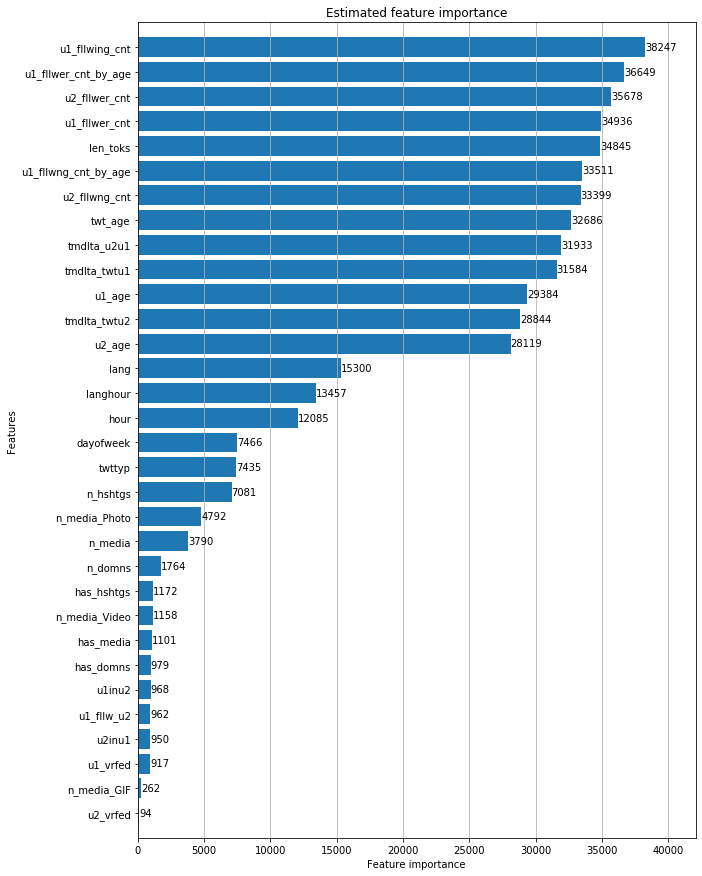

In [39]:
ax = lgb.plot_importance(bst, height=0.8, max_num_features=50, figsize=(10,15))
ax.grid(False, axis="y")
ax.set_title(f'Estimated feature importance')
plt.show()

In [40]:
pd.DataFrame([bst.feature_name(), bst.feature_importance()]).T.sort_values(1, ascending=False)

,0,1
3,u1_fllwing_cnt,38247
29,u1_fllwer_cnt_by_age,36649
5,u2_fllwer_cnt,35678
2,u1_fllwer_cnt,34936
11,len_toks,34845
30,u1_fllwng_cnt_by_age,33511
6,u2_fllwng_cnt,33399
26,twt_age,32686
23,tmdlta_u2u1,31933
24,tmdlta_twtu1,31584


In [41]:
col2imp = dict(zip(bst.feature_name(), bst.feature_importance()))
sorted(col2imp.items(), key=lambda x: -x[1])

[('u1_fllwing_cnt', 38247),
 ('u1_fllwer_cnt_by_age', 36649),
 ('u2_fllwer_cnt', 35678),
 ('u1_fllwer_cnt', 34936),
 ('len_toks', 34845),
 ('u1_fllwng_cnt_by_age', 33511),
 ('u2_fllwng_cnt', 33399),
 ('twt_age', 32686),
 ('tmdlta_u2u1', 31933),
 ('tmdlta_twtu1', 31584),
 ('u1_age', 29384),
 ('tmdlta_twtu2', 28844),
 ('u2_age', 28119),
 ('lang', 15300),
 ('langhour', 13457),
 ('hour', 12085),
 ('dayofweek', 7466),
 ('twttyp', 7435),
 ('n_hshtgs', 7081),
 ('n_media_Photo', 4792),
 ('n_media', 3790),
 ('n_domns', 1764),
 ('has_hshtgs', 1172),
 ('n_media_Video', 1158),
 ('has_media', 1101),
 ('has_domns', 979),
 ('u1inu2', 968),
 ('u1_fllw_u2', 962),
 ('u2inu1', 950),
 ('u1_vrfed', 917),
 ('n_media_GIF', 262),
 ('u2_vrfed', 94)]

In [42]:
[o[0] for o in sorted(col2imp.items(), key=lambda x: -x[1]) if o[1]>0]

['u1_fllwing_cnt',
 'u1_fllwer_cnt_by_age',
 'u2_fllwer_cnt',
 'u1_fllwer_cnt',
 'len_toks',
 'u1_fllwng_cnt_by_age',
 'u2_fllwng_cnt',
 'twt_age',
 'tmdlta_u2u1',
 'tmdlta_twtu1',
 'u1_age',
 'tmdlta_twtu2',
 'u2_age',
 'lang',
 'langhour',
 'hour',
 'dayofweek',
 'twttyp',
 'n_hshtgs',
 'n_media_Photo',
 'n_media',
 'n_domns',
 'has_hshtgs',
 'n_media_Video',
 'has_media',
 'has_domns',
 'u1inu2',
 'u1_fllw_u2',
 'u2inu1',
 'u1_vrfed',
 'n_media_GIF',
 'u2_vrfed']

# eval

In [ ]:
%%time
prdtr = bst.predict(dftr[cols_feat],num_iteration=bst.best_iteration)
prdvl = bst.predict(dfvl[cols_feat],num_iteration=bst.best_iteration)
prdval0 = bst.predict(dfval[cols_feat],num_iteration=bst.best_iteration)
prdval = calibration(prdval0, train_pop, target_pop, sampled_train_pop, sampled_target_pop)

In [ ]:
%%time
ytr,yvl,yval=[df[TCOL].values for df in (dftr,dfvl,dfval)]

auc_tr=compute_prauc(prdtr, ytr)
rce_tr=compute_rce(prdtr, ytr)
auc_vl=compute_prauc(prdvl, yvl)
rce_vl=compute_rce(prdvl, yvl)
auc_val=compute_prauc(prdval, yval)
rce_val=compute_rce(prdval, yval)

results['scrs'] = {}
results['scrs']['auc_tr']=auc_tr
results['scrs']['rce_tr']=rce_tr
results['scrs']['auc_vl']=auc_vl
results['scrs']['rce_vl']=rce_vl
results['scrs']['auc_val']=auc_val
results['scrs']['rce_val']=rce_val

In [37]:
print(f'auc_tr:  {auc_tr:.4f}')
print(f'auc_vl:  {auc_vl:.4f}')
print(f'auc_val: {auc_val:.4f}')
print()
print(f'rce_tr:  {rce_tr:.4f}')
print(f'rce_vl:  {rce_vl:.4f}')
print(f'rce_val: {rce_val:.4f}')

auc_tr:  0.4747
auc_vl:  0.3677
auc_val: 0.3497

rce_tr:  23.3252
rce_vl:  15.8424
rce_val: 14.4048


## score

In [38]:
print(f'-{auc_val:.4f}-{rce_val:.4f}')

-0.3497-14.4048


# save results

In [ ]:
pickle.dump(results, open(f'{p_out}/results_{PRFX}.p', 'wb'))

# infer

In [ ]:
results = pickle.load( open(f'{p_out}/results_{PRFX}.p', 'rb'))
bst = results['bst']
cols_feat = results['cols_feat']

## prep

In [ ]:
%%time
dftst=pd.read_csv(
    f'{p_in}/val_{tsttmstmp}.tsv',
    sep='\x01', header=None, names=cols_val, 
#     nrows=10
)

In [43]:
dftst.shape

(12434735, 34)

In [ ]:
%%time
dftst=prp_df(dftst, tm_max=tm_tst_max)

In [ ]:
dftst.drop(columns=['u1id','u1u2'], inplace=True)
cols_category=['twttyp', 'lang', 'langhour']
dftst[cols_category]=dftst[cols_category].astype('category')

## predict

In [ ]:
%%time
prdtst0 = bst.predict(dftst[cols_feat],num_iteration=bst.best_iteration)
prdtst = calibration(prdtst0, train_pop, target_pop, sampled_train_pop, sampled_target_pop)

In [ ]:
dfsub_ids = dftst[['twtid','u2id',]]
dfsub = dfsub_ids.copy()
dfsub['scr'] = prdtst
dfsub.to_csv(f'{p_out}/{TGT}__{PRFX}.csv',index=False,header=False)